[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/moshi4/pyCirclize/blob/main/docs/plot_tips.ipynb)

In [1]:
# %pip install pycirclize 

## Subplots

pyCirclize supports plotting to user-defined Polar Axes. Users can target subplot Polar Axes with the `circos.plotfig()` method to combine them with other plots.

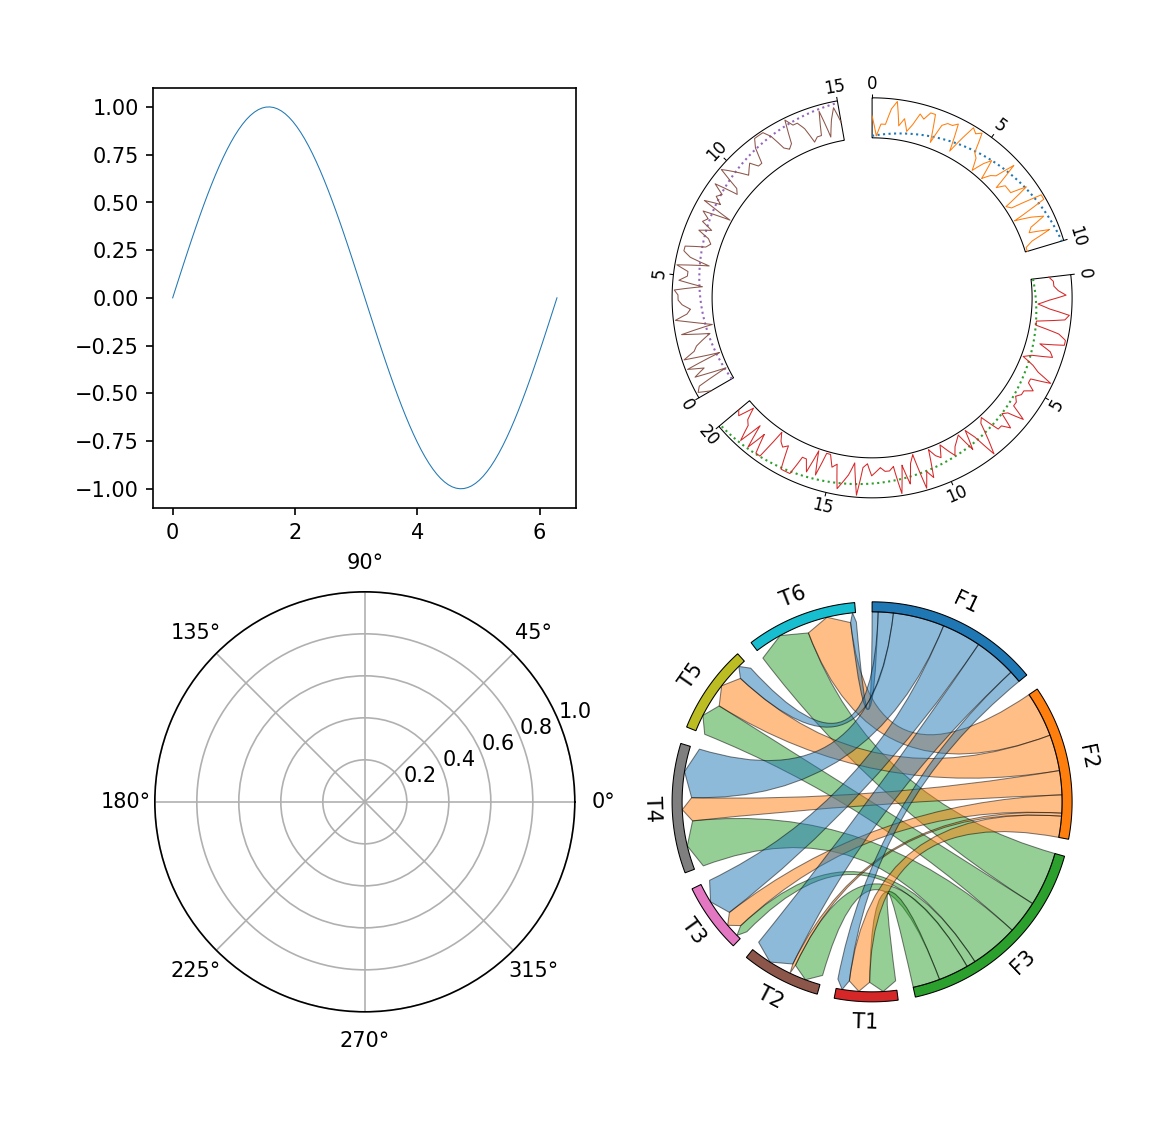

In [2]:
from pycirclize import Circos
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(0)

# Create 4 subplots
fig = plt.figure(figsize=(8, 8), dpi=150)
ax1 = fig.add_subplot(221)
polar_ax2 = fig.add_subplot(222, polar=True)
polar_ax3 = fig.add_subplot(223, polar=True)
polar_ax4 = fig.add_subplot(224, polar=True)

# Plot to first subplot (ax1)
x = np.linspace(0, 2 * np.pi, 100)
ax1.plot(x, np.sin(x))

# Plot circos to second subplot (polar_ax2)
sectors = {"A": 10, "B": 20, "C": 15}
circos = Circos(sectors, space=10)
for sector in circos.sectors:
    track = sector.add_track((80, 100), r_pad_ratio=0.1)
    track.axis()
    track.xticks_by_interval(5)
    vmin, vmax = 0, 10
    # Line between start-end two points
    track.line([track.start, track.end], [vmin, vmax], lw=1, ls="dotted")
    # Line of random value points
    x = np.linspace(track.start, track.end, int(track.size) * 5 + 1)
    y = np.random.randint(vmin, vmax, len(x))
    track.line(x, y)

fig = circos.plotfig(ax=polar_ax2)

# Plot chord diagram to fourth subplot (polar_ax4)
row_names = ["F1", "F2", "F3"]
col_names = ["T1", "T2", "T3", "T4", "T5", "T6"]
matrix_data = [
    [4, 14, 13, 17, 5, 2],
    [7, 1, 6, 8, 12, 15],
    [9, 10, 3, 16, 11, 18],
]
matrix_df = pd.DataFrame(matrix_data, index=row_names, columns=col_names)

circos = Circos.initialize_from_matrix(
    matrix_df,
    r_lim=(95, 100),
    space=5,
    cmap="tab10",
    link_kws=dict(ec="black", lw=0.5, direction=1),
)
fig = circos.plotfig(ax=polar_ax4)

## Grouping Sectors

In pyCirclize, the space size between sectors can be set arbitrarily. 
By using the `calc_group_spaces` function, users can easily get the sector space size setting 
within/between groups based on the number of groups.
Groups can be explicitly visualized as shown in the code example below.

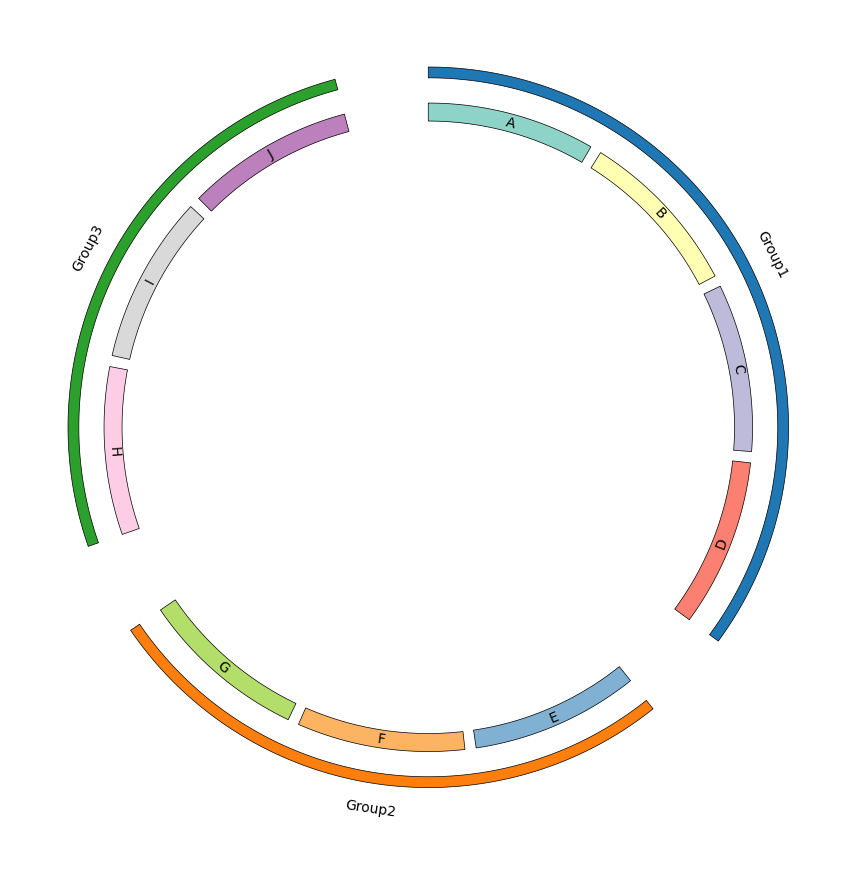

In [3]:
from pycirclize import Circos
from pycirclize.utils import calc_group_spaces, ColorCycler

sectors = {name: 10 for name in "ABCDEFGHIJ"}
group1, group2, group3 = list("ABCD"), list("EFG"), list("HIJ")

# Calculate appropriate group between/within spaces
# In this example, 10 sectors are displayed as groups dividied into [4, 3, 3]
spaces = calc_group_spaces([4, 3, 3], space_bw_group=15, space_in_group=2)
circos = Circos(sectors, space=spaces)

# Plot sector track
ColorCycler.set_cmap("Set3")
for sector in circos.sectors:
    track = sector.add_track(r_lim=(85, 90))
    track.axis(fc=ColorCycler())
    track.text(sector.name)

# Plot group sectors range
ColorCycler.set_cmap("tab10")
for idx, group in enumerate((group1, group2, group3), 1):
    group_deg_lim = circos.get_group_sectors_deg_lim(group)
    circos.rect(r_lim=(97, 100), deg_lim=group_deg_lim, fc=ColorCycler(), ec="black", lw=0.5)
    group_center_deg = sum(group_deg_lim) / 2
    circos.text(f"Group{idx}", r=105, deg=group_center_deg, adjust_rotation=True)

fig = circos.plotfig()

## Colorbar

Users can easily plot colorbars with `circos.colorbar()` method.

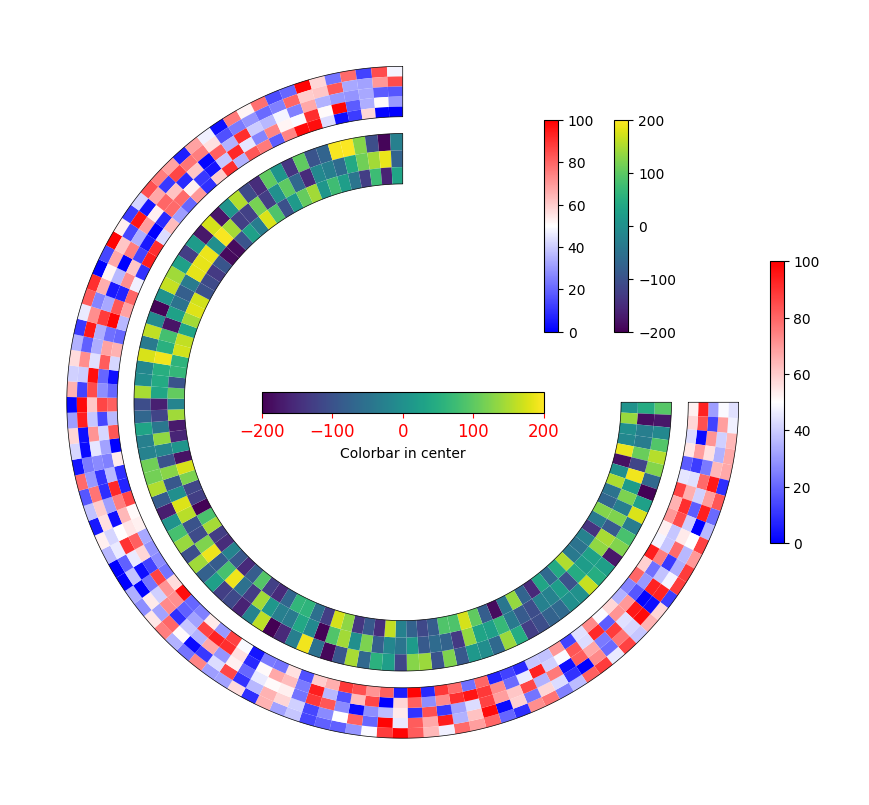

In [4]:
from pycirclize import Circos
import numpy as np
np.random.seed(0)

# Initialize Circos instance
circos = Circos(sectors=dict(data=100), start=90)
sector = circos.sectors[0]

# Plot heatmap track1 (cmap="bwr")
track1 = sector.add_track((85, 100))
track1.axis()
vmin1, vmax1, cmap1 = 0, 100, "bwr"
matrix1 = np.random.randint(vmin1, vmax1, (5, 100))
track1.heatmap(matrix1, cmap=cmap1, vmin=vmin1, vmax=vmax1)

# Plot heatmap track2 (cmap="viridis")
track2 = sector.add_track((65, 80))
track2.axis()
vmin2, vmax2, cmap2 = -200, 200, "viridis"
matrix2 = np.random.randint(vmin2, vmax2, (3, 100))
track2.heatmap(matrix2, cmap=cmap2, vmin=vmin2, vmax=vmax2)

# Plot colorbar in various style
# bounds = (x, y, width, height)
circos.colorbar(vmin=vmin1, vmax=vmax1)
circos.colorbar(bounds=(0.7, 0.6, 0.02, 0.3), vmin=vmin1, vmax=vmax1, cmap="bwr")
circos.colorbar(bounds=(0.8, 0.6, 0.02, 0.3), vmin=vmin2, vmax=vmax2, cmap="viridis")
circos.colorbar(
    bounds=(0.3, 0.485, 0.4, 0.03),
    vmin=vmin2,
    vmax=vmax2,
    cmap="viridis",
    orientation="horizontal",
    colorbar_kws=dict(label="Colorbar in center"),
    tick_kws=dict(labelsize=12, colors="red"),
)

fig = circos.plotfig()

## Legend

Example of manual legend plotting code using [`Axes.legend()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html) method.  
See [Legend guide](https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html) for more details.

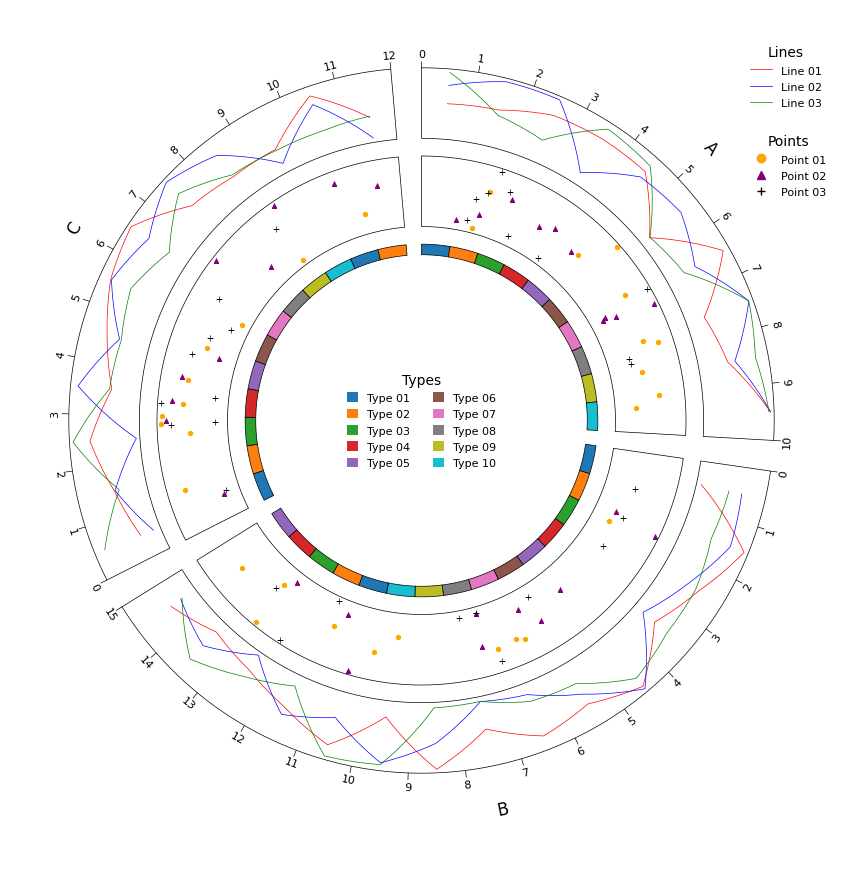

In [5]:
from pycirclize import Circos
from pycirclize.utils import ColorCycler
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
np.random.seed(0)

line_colors = ("red", "blue", "green")
scatter_colors = ("orange", "purple", "black")
scatter_markers = ("o", "^", "+")
cmap_name = "tab10"

sectors = dict(A=10, B=15, C=12)
circos = Circos(sectors, space=5)
for sector in circos.sectors:
    sector.text(sector.name, r=110, size=12)
    # Plot line track
    track1 = sector.add_track((80, 100), r_pad_ratio=0.1)
    track1.axis()
    track1.xticks_by_interval(interval=1)
    for line_color in line_colors:
        x = np.arange(sector.start, sector.end) + 0.5
        y = np.random.randint(0, 100, len(x))
        track1.line(x, y, color=line_color)
    # Plot scatter track
    track2 = sector.add_track((55, 75), r_pad_ratio=0.1)
    track2.axis()
    for color, marker in zip(scatter_colors, scatter_markers):
        point_num = 10
        x = np.random.rand(point_num) * (sector.end - 1) + 0.5
        y = np.random.rand(point_num) * 10
        track2.scatter(x, y, c=color, marker=marker, s=15)
    # Plot rect track
    track3 = sector.add_track((47, 50))
    ColorCycler.set_cmap(cmap_name)
    for idx in range(int(sector.start), int(sector.end)):
        track3.rect(idx, idx + 1, color=ColorCycler(), ec="black", lw=0.5)

fig = circos.plotfig()

# Plot legend
line_handles = [
    Line2D([], [], color="red", label="Line 01"),
    Line2D([], [], color="blue", label="Line 02"),
    Line2D([], [], color="green", label="Line 03"),
]
line_legend = circos.ax.legend(
    handles=line_handles,
    bbox_to_anchor=(0.93, 1.02),
    fontsize=8,
    title="Lines",
    handlelength=2,
)
circos.ax.add_artist(line_legend)

scatter_handles = [
    # Marker List: https://matplotlib.org/stable/api/markers_api.html
    Line2D([], [], color="orange", marker="o", label="Point 01", ms=6, ls="None"),
    Line2D([], [], color="purple", marker="^", label="Point 02", ms=6, ls="None"),
    Line2D([], [], color="black", marker="+", label="Point 03", ms=6, ls="None"),
]
scatter_legend = circos.ax.legend(
    handles=scatter_handles,
    bbox_to_anchor=(0.93, 0.90),
    fontsize=8,
    title="Points",
    handlelength=2,
)
circos.ax.add_artist(scatter_legend)

rect_handles = []
rect_colors = ColorCycler.get_color_list()
for idx, color in enumerate(rect_colors, 1):
    rect_handles.append(Patch(color=color, label=f"Type {idx:02d}"))
_ = circos.ax.legend(
    handles=rect_handles,
    bbox_to_anchor=(0.5, 0.5),
    loc="center",
    fontsize=8,
    title="Types",
    ncol=2,
)